# Segmentation and feature detection

**Authors:** Anders Bjorholm Dahl (abda@dtu.dk) and Vedrana Andersen Dahl (vand@dtu.dk)

In this exercise, you will compute the diameter of glass fibers from images of a fiber composite. The images are obtained from a scanning electron microscope (SEM), an optical microscope, and a slice from an X-ray computed tomography (CT) image acquired at a synchrotron facility.

The task is to determine the fiber diameters computed using the different imaging techniques. The image from the optical microscope directly depicts the fibers, but the polished surface of the composite has some imaging artefacts. From the SEM images are acquired in lower resolution but with a very high contrast. Here the surface has been coated with gold before the image has been acquired. CT has more noise and similar resolutions as SEM, but the images are in 3D allowing a richer characterization. The question is if the sizes computed from CT is the same as SEM and optical microscopy.

The image analysis is done by the following steps:
1. Read in image
2. Display histogram and determine good threshold
3. Threshold image and count number of fiber pixels
4. Design a smoothing filter and filter image
5. Find location of local maxima inside fibers
6. Display image with fiber centers plotted on top
7. Find average size by dividing pixel count and fiber count and compute diameter - transform from pixels to physical size
8. Repeat 1-7 for optical image
9. Compare result and discuss

By carrying out the exercise you will become familiar with reading and displaying images, histogram, threshold, filtering, and techniques for feature location. These are some basic tools in image analysis that you will become familiar with.

## Load libraries
Analyzing images requires a number of libraries that is read in below.

In [ ]:
# Load relevant libraries
# scikit-image for image processing 
import skimage as sk
import skimage.io as skio

import scipy.ndimage as snd

# Plot functions
import matplotlib.pyplot as plt
%matplotlib inline

# Nummerical library
import numpy as np

# System library e.g. for opening files in a library
import os

# Read images remotely
import urllib.request
import PIL

## 1. Read and display images
Here you will load the images into memory and display them. Pixel size of the CT image is 1.00 $\mu$m, for the SEM image it is 1.03 $\mu$m, and for the optical microcope image it is 1.11 $\mu$m.

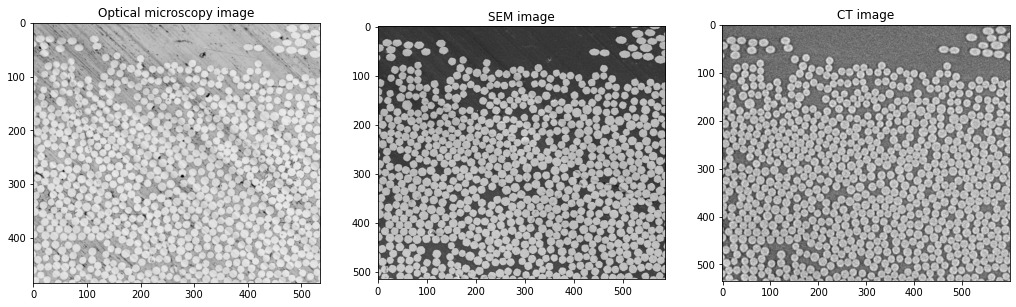

In [ ]:
# Load images of fibres. All three images are loaded and displayed here, but later the optical image is used for 
# further processing. 
in_dir = '../data/'
url = 'https://qim.compute.dtu.dk/data-repository/demo_data/'
im_names = ['fiber_im_sem.png', 'fiber_im_ct.png', 'fiber_im_opt.png']

# Read images
im_sem = np.array(PIL.Image.open(urllib.request.urlopen(url + im_names[0]))).astype(np.uint8)
im_ct = np.array(PIL.Image.open(urllib.request.urlopen(url + im_names[1]))).astype(np.uint8)
im_opt = np.array(PIL.Image.open(urllib.request.urlopen(url + im_names[2]))).astype(np.uint8)


# Show images
fig, ax = plt.subplots(1, 3, figsize=(17.5,7.5))
ax[0].imshow(im_opt,cmap="gray")
ax[0].set_title('Optical microscopy image')
ax[1].imshow(im_sem,cmap="gray")
ax[1].set_title('SEM image')
ax[2].imshow(im_ct,cmap="gray")
ax[2].set_title('CT image')
fig.show()

## 2. Display histogram
The histogram is a bar plot showing the number of pixels in a set of equally spaced bins. Here the number of bins is given as an argument, and since this is an 8 bit image and contains 256 unique values, it is a natural choice to set the number of bins to 256.

In [ ]:
# Choose the image to compute
im = im_opt;

# Compute the histogram
plt.figure(figsize=(12,5))

# The function hist takes a 1D array as input, and therefore the numpy function is called to convert the image to a 
# 1D array.
plt.hist(im.ravel(),256)
plt.show()

## 3. Threshold image
From the histogram it looks like there are two distributions separated by a valley at pixel values in the range 195-200. We choose a threshold to be 195.

In [ ]:
# Threshold the image

# Set threshold variable
tval = 195

# Use logical expression to threshold. This will result in a boolean type (true or false), but we later want to use 
# it as unsigned 8 bit integer, so we change the type
im_thres = (im > tval).astype(np.uint8)
# Type can be determined by the expression: print('Type is: ', im_thres.dtype)

# Show the thresholded image
plt.figure(figsize=[12,8])
plt.imshow(im_thres,cmap="gray")
plt.title('Thresholded optical microscopy image')
plt.show()

## 4. Design a smoothing filter and filter the image
If we smooth the image with an appropriate filter, we can hope to obtain a local maximum at each fiber. This is the approach we will take, and therefore we will create a Gaussian filter.

In [ ]:
# Filter the image - first make a Gaussian filter
# Scale parameter
s = 2.5
f = (-np.ceil(3*s)).astype(int)
t = (np.ceil(3*s)).astype(int)
x = np.linspace(f, t, t-f+1)
g = np.exp(-x**2/(2*s**2))
g = g/np.sum(g)
g = g[:,None] # need a 2D array

# Show the filter kernel
plt.figure(figsize=[13,7])
plt.subplot(121)
plt.plot(x, g, '-o')
plt.title('Gaussian filter')

# Apply the Gaussian filter (two orthogonal 1D filters)
im_filt = snd.convolve(snd.convolve(im.astype(float), g, mode='reflect'), g.T, mode='reflect') 

# Show the filtered image
plt.subplot(122)
plt.imshow(im_filt, cmap='jet')
plt.title('Filtered image')
plt.show()

## 5. Find location of local maxima inside fibers
The local maxima are found by comparing pixels to its neighbours. Typically, the pixel is compared to the four or eight nearest neighbours - here we have chosen an eight neighbourhood. This is done by making an image of the same size as the original image and using it for counting how many of the neighbors that are smaller than the current pixel. Pixels where this count is eight is a local maximum.

In [ ]:
# Image container to count number of time a pixel is larger than its neighbor
r,c = np.shape(im)
im_count = np.zeros((r,c)).astype(np.float)

# Count pixels that are larger than neighbours
for i in range(-1,2):
    for j in range(-1,2):
        tmp = im_filt[1:r-2,1:c-2] > im_filt[1+i:r-2+i,1+j:c-2+j]
        im_count[1:r-2,1:c-2] += tmp.astype(float)

# Show the count image
plt.figure(figsize=[12,7])
plt.imshow(im_count)
plt.show()

## 6. Display image with fibre centres plotted on top

In [ ]:
# Find maximum as pixels that has counted to eight and that has a value larger than the threshold value
idx = np.nonzero(np.logical_and(im_count==8, im_filt>tval))

# Plot the found points
plt.figure(figsize=[10,10])
plt.imshow(im, cmap='gray')
plt.scatter(idx[1], idx[0], c='r', s=10)
plt.show()

## 7. Average fiber size
The fibres are assumed to be circular and the numbers are counted from the analysis above.

In [ ]:
# Number of pixels that are fibers
n_fib_pix = np.sum(im_thres)
print('Number of fiber pixels:      ', n_fib_pix)

# The number of fibers can be obtained from the idx-array
(c, n_fib) = np.shape(idx)
print('Number of fibers:               ', n_fib)

# Compute the average area of the fibers
area_fib_pix = n_fib_pix/n_fib
print('Number of pixels in each fiber:  %.2f' % area_fib_pix)

# Compute the diameter in pixels
d_pix = 2*np.sqrt(area_fib_pix/np.pi)
print('Diameter of fiber in pixels:      %.2f' % d_pix)

# Compute the diameter in microns
pix_size = 1.11
d = d_pix*pix_size
print('Diameter of fiber in microns:     %.2f' % d)